<a href="https://colab.research.google.com/github/yujeonghyeop/Bitcoin-Anomaly-Transaction-Detection/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve,roc_auc_score,fbeta_score,recall_score
from sklearn.metrics import plot_precision_recall_curve,average_precision_score,f1_score
from sklearn.metrics import plot_roc_curve
from sklearn import metrics
from sklearn.svm import SVC

sns.set(style="whitegrid")
np.random.seed(203)

In [ ]:
raw_features=pd.read_csv("https://media.githubusercontent.com/media/GuyenSoto/BTC/master/elliptic_txs_features.csv")
raw_classes=pd.read_csv("https://media.githubusercontent.com/media/GuyenSoto/BTC/master/elliptic_txs_classes.csv")
raw_edgelist=pd.read_csv("https://media.githubusercontent.com/media/GuyenSoto/BTC/master/elliptic_txs_edgelist.csv")

In [ ]:
raw_features.columns = ['id', 'time'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
raw_features.head()

,id,time,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540


In [ ]:
raw_features = pd.merge(raw_features, raw_classes, left_on='id', right_on='txId', how='left')

In [ ]:
data = raw_features.copy()
data.head()

,id,time,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,...,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,txId,class
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,5530458,unknown
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,232022460,unknown
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,232438397,2
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,230460314,unknown
4,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540,230459870,unknown


In [ ]:
data.pop('txId')
data.pop('time')
data.pop('id')
data.head()

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,class
0,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown
1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,unknown
2,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2
3,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,unknown
4,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,0.038305,0.816377,...,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540,unknown


In [ ]:
mask = data['class'].isin(['unknown'])
data = data[~mask]
data

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,class
2,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2
8,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,0.020069,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,2
9,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,-0.049707,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
10,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,-0.049707,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
15,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,-0.169115,-0.047227,...,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203751,-0.159293,-0.037276,1.018602,-0.121970,0.035526,-0.113002,-0.061584,-0.149635,-0.155646,-0.049707,...,1.408971,0.231244,-0.388216,-0.098889,1.931078,3.168259,3.707301,-1.390548,-1.214035,2
203753,-0.172962,-0.126566,1.018602,-0.121970,-0.063725,-0.113002,-0.061584,-0.163622,-0.169437,-0.049707,...,0.647874,0.241128,0.241406,10.914916,1.700384,-0.131155,7.914145,-0.120613,-0.119792,2
203758,-0.170412,-0.078164,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163631,-0.167106,-0.032993,...,1.606604,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1
203762,-0.093732,-0.116160,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.082559,-0.089510,-0.049707,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2


In [ ]:
data.pop('agg_feat_17')
data.pop('agg_feat_58')
data.pop('agg_feat_59')
data.pop('agg_feat_35')
data.pop('agg_feat_16')
data.pop('agg_feat_34')
data.pop('agg_feat_42')
data.pop('agg_feat_22')
data.pop('agg_feat_52')
data.pop('agg_feat_23')
data.pop('agg_feat_53')
data.pop('agg_feat_28')
data.pop('agg_feat_11')
data.pop('agg_feat_29')
data.pop('agg_feat_10')
data.pop('agg_feat_7')
data.pop('agg_feat_66')
data.pop('agg_feat_41')
data.pop('agg_feat_9')
data.pop('agg_feat_40')
data.pop('agg_feat_5')
data.pop('agg_feat_4')
data.pop('agg_feat_45')
data.pop('agg_feat_6')
data.pop('agg_feat_21')
data.pop('agg_feat_65')
data.pop('agg_feat_64')
data.pop('agg_feat_67')
data.pop('agg_feat_46')
#29

2         0.183133
8         0.183133
9        -0.975738
10       -0.975738
15        1.342003
            ...   
203751    0.941972
203753    0.183133
203758   -0.975738
203762   -0.975738
203765   -0.975738
Name: agg_feat_46, Length: 46564, dtype: float64

In [ ]:
data.pop('trans_feat_6')
data.pop('trans_feat_38')
data.pop('trans_feat_37')
data.pop('trans_feat_69')
data.pop('trans_feat_14')
data.pop('trans_feat_72')
data.pop('trans_feat_56')
data.pop('trans_feat_71')
data.pop('trans_feat_55')
data.pop('trans_feat_49')
data.pop('trans_feat_43')
data.pop('trans_feat_50')
data.pop('trans_feat_87')
data.pop('trans_feat_15')
data.pop('trans_feat_13')
data.pop('trans_feat_4')
data.pop('trans_feat_44')
data.pop('trans_feat_33')
data.pop('trans_feat_36')
data.pop('trans_feat_35')
data.pop('trans_feat_70')
data.pop('trans_feat_2')
data.pop('trans_feat_34')
data.pop('trans_feat_32')
data.pop('trans_feat_26')
data.pop('trans_feat_63')
data.pop('trans_feat_57')
data.pop('trans_feat_25')
data.pop('trans_feat_31')
data.pop('trans_feat_12')
data.pop('trans_feat_9')
data.pop('trans_feat_81')
data.pop('trans_feat_75')
#33

2         4.313295
8         4.313295
9        -0.095403
10       -0.095403
15       -0.095403
            ...   
203751   -0.095328
203753   -0.095253
203758   -0.095403
203762   -0.095253
203765   -0.095403
Name: trans_feat_75, Length: 46564, dtype: float64

In [ ]:
data

,trans_feat_0,trans_feat_1,trans_feat_3,trans_feat_5,trans_feat_7,trans_feat_8,trans_feat_10,trans_feat_11,trans_feat_16,trans_feat_17,...,agg_feat_57,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,class
2,0.163054,1.963790,12.409294,9.782742,-0.163645,-0.115831,-0.163905,1.059993,0.174329,-0.172908,...,-1.071885,-0.216814,-0.617907,-0.577099,-0.613614,-0.131155,0.677799,-0.120613,-0.119792,2
8,-0.005027,0.578941,4.380281,4.667146,-0.163645,-0.144554,-0.163135,1.696691,0.001525,-0.172908,...,-1.071885,-0.216814,-0.617907,-0.577099,-0.613614,-0.131155,0.333211,-0.120613,-0.119792,2
9,-0.147852,-0.184668,-0.121970,-0.113002,-0.137933,-0.144108,-0.140266,-0.028741,-0.148916,-0.151494,...,-1.678997,-0.216814,-0.617907,-0.577099,-0.613614,-0.131155,-0.097524,-0.120613,-0.119792,2
10,-0.151357,-0.184668,-0.121970,-0.113002,-0.141519,-0.147643,-0.143847,-0.028741,-0.150266,-0.150457,...,-1.678997,-0.216814,-0.587217,-0.539735,-0.582077,-0.131155,-0.097524,-0.120613,-0.119792,2
15,-0.172306,-0.184668,0.028105,-0.029140,-0.163640,-0.169115,-0.165719,-2.222844,-0.170460,-0.172121,...,-1.678997,-0.193143,-0.611769,-0.577099,-0.600999,-0.084674,-0.054450,-1.760926,-1.760984,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203751,-0.159293,-0.037276,-0.121970,-0.113002,-0.149635,-0.155646,-0.151955,-0.028741,-0.161423,-0.166686,...,1.053007,-0.216814,3.132493,1.793987,1.408971,3.168259,3.707301,-1.390548,-1.214035,2
203753,-0.172962,-0.126566,-0.121970,-0.113002,-0.163622,-0.169437,-0.165926,-0.028741,-0.171129,-0.172908,...,1.963675,2.150311,-0.004094,-0.577099,0.647874,-0.131155,7.914145,-0.120613,-0.119792,2
203758,-0.170412,-0.078164,0.028105,0.054722,-0.163631,-0.167106,-0.165073,2.220787,-0.168569,-0.170013,...,1.660119,0.327624,1.401539,1.709623,1.606604,-0.131155,-0.097524,-0.120613,-0.119792,1
203762,-0.093732,-0.116160,-0.121970,-0.113002,-0.082559,-0.089510,-0.084953,-0.028741,-0.090105,-0.080260,...,0.749451,-0.216814,-0.617907,-0.577099,-0.613614,-0.131155,-0.097524,-0.120613,-0.119792,2


In [ ]:
std_data = preprocessing.StandardScaler().fit_transform(data)
std_data

array([[ 0.30702549,  1.16882093,  7.64380734, ...,  0.59344234,
        -0.08332004, -0.08205159],
       [ 0.06777975,  0.27191143,  2.62853886, ...,  0.27002021,
        -0.08332004, -0.08205159],
       [-0.13551708, -0.22264614, -0.18376122, ..., -0.13425746,
        -0.08332004, -0.08205159],
       ...,
       [-0.16762877, -0.15366794, -0.09001788, ..., -0.13425746,
        -0.08332004, -0.08205159],
       [-0.05848288, -0.17827679, -0.18376122, ..., -0.13425746,
        -0.08332004, -0.08205159],
       [-0.16990809, -0.15367967, -0.09001788, ..., -0.13425746,
        -0.08332004, -0.08205159]])

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
std_data = pd.DataFrame(std_data, index = data.index, columns = data.columns[:-1])
std_data.head()

,trans_feat_0,trans_feat_1,trans_feat_3,trans_feat_5,trans_feat_7,trans_feat_8,trans_feat_10,trans_feat_11,trans_feat_16,trans_feat_17,...,agg_feat_56,agg_feat_57,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
2,0.307025,1.168821,7.643807,6.039024,-0.146334,-0.084347,-0.153187,0.934397,0.341122,-0.210304,...,-1.011217,-1.132219,-0.276796,-0.618518,-0.570335,-0.619017,-0.117599,0.593442,-0.08332,-0.082052
8,0.067780,0.271911,2.628539,2.820415,-0.146334,-0.127352,-0.151894,1.412261,0.086508,-0.210304,...,-1.011217,-1.132219,-0.276796,-0.618518,-0.570335,-0.619017,-0.117599,0.270020,-0.08332,-0.082052
9,-0.135517,-0.222646,-0.183761,-0.187137,-0.102664,-0.126685,-0.113486,0.117265,-0.135156,-0.156921,...,-1.011217,-1.720638,-0.276796,-0.618518,-0.570335,-0.619017,-0.117599,-0.134257,-0.08332,-0.082052
10,-0.140505,-0.222646,-0.183761,-0.187137,-0.108753,-0.131978,-0.119501,0.117265,-0.137146,-0.154337,...,-1.011217,-1.720638,-0.276796,-0.587180,-0.529548,-0.586053,-0.117599,-0.134257,-0.08332,-0.082052
15,-0.170324,-0.222646,-0.090018,-0.134373,-0.146324,-0.164128,-0.156233,-1.529485,-0.166900,-0.208343,...,-1.011217,-1.720638,-0.251272,-0.612250,-0.570335,-0.605832,-0.091257,-0.093830,-1.72568,-1.726407


In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components= 103)
pca_array = pca.fit_transform(std_data)
pca_df = pd.DataFrame(pca_array, index = std_data.index, columns = [f"pca{num+1}" for num in range(std_data.shape[1])])
pca_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca94,pca95,pca96,pca97,pca98,pca99,pca100,pca101,pca102,pca103
0,-1.229614,-0.377434,-0.146951,-1.805586,-0.627778,-2.173855,1.736255,-0.747641,-0.721562,0.099674,...,0.000168,0.000127,0.000057,0.000025,0.000013,0.000003,0.000004,-0.000002,-5.073027e-07,-6.132227e-07
1,-1.742592,-0.060902,0.879120,2.241520,-3.964767,-1.711083,1.482733,-2.023832,-1.909282,1.228105,...,0.000085,0.000441,-0.000249,-0.000045,0.000040,0.000001,0.000006,-0.000001,-7.909461e-07,4.394508e-07
2,1.660557,0.411989,3.178769,1.169662,-0.164118,5.247739,2.882395,-3.383630,-2.558233,-4.175657,...,-0.012550,-0.002302,0.000070,-0.000242,-0.000363,-0.000044,0.000038,-0.000014,-7.078139e-06,6.260890e-06
3,-1.594401,1.320887,0.616548,-0.480464,-2.221957,1.052973,2.033637,0.075266,-1.311145,-0.342608,...,-0.003976,-0.005978,-0.009234,-0.000770,-0.003221,-0.000031,0.000029,-0.000013,4.275538e-06,-6.891341e-06
4,-1.451652,1.102597,0.680112,-0.398795,-1.465382,1.712624,0.623213,0.369495,-1.579931,-0.036100,...,-0.004955,-0.004098,0.000245,-0.000784,-0.003290,0.000001,0.000066,0.000023,4.132468e-06,-9.583565e-06


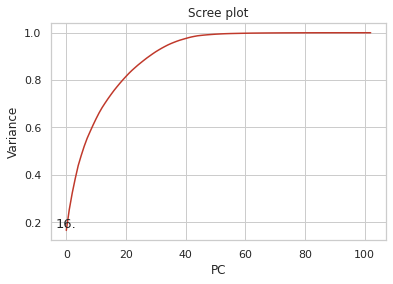

In [ ]:
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_ 
    
    ax = plt.subplot()
    cumvals = np.cumsum(vals)
    ax.plot(ind, cumvals, color = '#c0392b') # Line plot 
    
    for i in range(num_components): #라벨링(바 위에 텍스트(annotation) 쓰기)
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va = "bottom", ha = "center", fontsize = 13)
     
    ax.set_xlabel("PC")
    ax.set_ylabel("Variance")
    plt.title('Scree plot')
    
scree_plot(pca)

In [ ]:
result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(std_data.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()
result

,설명가능한 분산 비율(고윳값),기여율,누적기여율
pca1,1.702609e+01,1.653010e-01,0.165301
pca2,9.063651e+00,8.799618e-02,0.253297
pca3,7.248125e+00,7.036980e-02,0.323667
pca4,6.240788e+00,6.058987e-02,0.384257
pca5,5.681770e+00,5.516255e-02,0.439419
...,...,...,...
pca99,1.851736e-08,1.797793e-10,1.000000
pca100,6.621701e-09,6.428804e-11,1.000000
pca101,2.723105e-09,2.643778e-11,1.000000
pca102,9.024835e-10,8.761933e-12,1.000000


In [ ]:
gp = result.copy()
gp.pop('설명가능한 분산 비율(고윳값)')
gp.pop('기여율')
gp
plt.show()

In [ ]:
gp['누적기여율']

pca1      0.165301
pca2      0.253297
pca3      0.323667
pca4      0.384257
pca5      0.439419
            ...   
pca99     1.000000
pca100    1.000000
pca101    1.000000
pca102    1.000000
pca103    1.000000
Name: 누적기여율, Length: 103, dtype: float64

In [ ]:
data_1 = data.iloc[:,[k for k in range(60)]]
data_2 = data.iloc[:,[k for k in range(60,103)]]
data_2

,agg_feat_0,agg_feat_1,agg_feat_2,agg_feat_3,agg_feat_8,agg_feat_12,agg_feat_13,agg_feat_14,agg_feat_15,agg_feat_18,agg_feat_19,agg_feat_20,agg_feat_24,agg_feat_25,agg_feat_26,agg_feat_27,agg_feat_30,agg_feat_31,agg_feat_32,agg_feat_33,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_43,agg_feat_44,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,-0.170113,-0.202332,-0.116817,-0.192405,-0.083459,-0.166550,-0.216536,-0.134546,-0.194817,-1.096336,-1.267340,-0.349933,-0.116425,-0.176617,-0.137323,-0.152464,-0.093145,-0.143707,-0.097719,-0.127462,-0.121330,-0.110933,-0.075909,-0.111641,-1.353918,-0.295982,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-0.968903,0.146997,1.366287,-0.464773,-0.216814,0.634272,0.947382,0.673103,-0.131155,-0.097524,-0.120613,-0.119792
1,-0.170528,-0.202658,-0.116817,-0.192811,-0.083459,-0.166550,-0.216536,-0.134546,-0.194817,-1.096336,-1.267340,-0.349933,-0.116425,-0.176617,-0.137323,-0.152464,-0.095559,-0.145126,-0.097719,-0.129496,-0.122974,-0.041556,0.012549,-0.032244,-1.356210,-0.301548,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-0.968903,-1.421138,-0.453330,-1.375441,-0.216814,0.407161,0.670883,0.439728,-0.131155,-0.183671,-0.120613,-0.119792
2,-0.171098,0.266450,0.159432,-0.159946,-0.083124,-0.176219,-0.056011,-0.082822,-0.191696,-1.096336,0.787435,0.856163,-0.116425,0.312047,0.064623,-0.101755,-0.095559,0.523326,0.019771,-0.119195,0.759756,-0.041556,-0.188716,0.149949,-1.356131,-0.301754,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,-0.425896,-1.421138,-1.059868,-1.071885,-0.216814,-0.617907,-0.577099,-0.613614,-0.131155,0.677799,-0.120613,-0.119792
3,-0.162974,0.844932,1.723414,0.440298,-0.070389,-0.166550,-0.174293,-0.091258,-0.154707,-1.096336,-1.267340,-0.349933,-0.011925,1.228292,1.193497,1.471777,-0.093145,-0.116742,-0.077909,-0.093120,-0.101820,0.704558,0.448898,0.659662,-1.355393,-0.300941,-0.035232,-0.168742,-0.442156,-0.416540,-0.418273,-0.968903,-1.943850,-1.059868,-1.678997,-0.169472,-0.470592,-0.511871,-0.400422,0.326394,1.293750,0.178136,0.179117
4,-0.162974,0.530794,1.169424,0.365016,-0.082342,-0.133207,-0.174293,-0.112969,-0.149694,-1.096336,-1.267340,-0.349933,1.033067,1.289375,0.774169,1.677228,-0.047268,-0.116742,-0.097719,-0.088827,-0.101046,0.704558,0.382060,0.272503,-1.354445,-0.300062,-0.357362,-0.168742,-0.441465,-0.415693,-0.419836,-0.968903,-0.375715,-0.498323,-1.592267,-0.169472,-0.446040,-0.504702,-0.422589,0.413931,1.149556,-0.696053,-0.695540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203763,-0.152429,-0.188449,-0.116817,-0.175101,-0.083459,-0.151290,-0.204936,-0.134546,-0.180239,0.493811,0.273741,-0.349933,-0.116425,-0.176617,-0.137323,-0.152464,-0.093145,-0.143707,-0.097719,-0.127462,-0.109152,-0.190385,-0.179561,-0.200445,1.197783,-0.296051,1.340733,-0.177903,-0.461001,-0.424672,-0.445534,0.117111,-0.898426,-1.059868,-0.464773,-0.216814,-0.617907,-0.577099,-0.613614,-0.131155,-0.097524,-0.120613,-0.119792
203764,0.622034,0.419553,-0.116817,0.582730,-0.083459,0.186899,0.052145,-0.134546,0.142823,1.553909,1.301128,-0.349933,-0.116425,-0.176617,-0.137323,-0.152464,0.085531,-0.038685,-0.097719,0.023013,-0.124671,-0.130919,-0.100522,-0.135301,1.193410,-0.299830,1.340733,-0.144378,0.247462,0.428908,0.252204,1.203124,1.192421,0.153209,1.356563,-0.216814,-0.010232,0.162722,0.010822,-0.084674,-0.140597,-1.760926,-1.760984
203765,-0.171045,0.000997,0.307001,-0.096389,-0.083459,-0.143822,-0.129159,0.009530,-0.143653,1.023860,1.301128,0.682652,-0.116425,-0.176617,-0.137323,-0.152464,-0.093145,-0.118161,-0.064212,-0.115262,-0.104735,0.164362,0.269830,0.208188,1.192963,-0.300724,-0.975237,1.086992,1.510479,1.506624,1.848556,2.289138,1.192421,-1.059868,1.963675,1.747899,1

In [ ]:
std_data_1 = preprocessing.StandardScaler().fit_transform(data_1)
std_data_1 = pd.DataFrame(std_data_1, index = data_1.index, columns = data_1.columns)
std_data_1.head()

,trans_feat_0,trans_feat_1,trans_feat_3,trans_feat_5,trans_feat_7,trans_feat_8,trans_feat_10,trans_feat_11,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_39,trans_feat_40,trans_feat_41,trans_feat_42,trans_feat_45,trans_feat_46,trans_feat_47,trans_feat_48,trans_feat_51,trans_feat_52,trans_feat_53,trans_feat_54,trans_feat_58,trans_feat_59,trans_feat_60,trans_feat_61,trans_feat_62,trans_feat_64,trans_feat_65,trans_feat_66,trans_feat_67,trans_feat_68,trans_feat_73,trans_feat_74,trans_feat_76,trans_feat_77,trans_feat_78,trans_feat_79,trans_feat_80,trans_feat_82,trans_feat_83,trans_feat_84,trans_feat_85,trans_feat_86,trans_feat_88,trans_feat_89,trans_feat_90,trans_feat_91,trans_feat_92
0,-0.171485,-0.184668,-0.121970,-0.113002,-0.162112,-0.167949,-0.164418,-0.028741,-0.169758,-0.171477,-0.174491,0.887053,0.884552,-0.139732,-0.148912,-0.080147,-0.155662,-0.139733,-0.148908,-0.080147,-0.155662,-0.227216,-0.239369,-0.075256,-0.234952,-0.227204,-0.243237,-0.097895,-0.235897,-0.413966,-0.488308,-0.232553,-0.467517,-0.172896,-0.163126,-0.160933,0.923468,0.923006,-0.172885,-0.163115,-0.160926,0.923511,0.923105,-0.140764,-0.140335,-0.264425,-0.250574,-0.263753,-0.169113,-0.167160,-0.262425,-0.255169,-0.259252,-0.187186,-0.185268,-0.760699,-0.692775,-0.719788,-1.084902,-1.084840
1,-0.172107,-0.184668,-0.121970,-0.113002,-0.162750,-0.168577,-0.165054,-0.028741,-0.170400,-0.172218,-0.175228,0.887053,0.884552,-0.139730,-0.148911,-0.080147,-0.155660,-0.139732,-0.148906,-0.080147,-0.155660,-0.227178,-0.239333,-0.075256,-0.234915,-0.227165,-0.243198,-0.097895,-0.235858,-0.268738,-0.367523,-0.232553,-0.328165,-0.172871,-0.163101,-0.160907,-1.316351,-1.315397,-0.172860,-0.163090,-0.160900,-1.316342,-1.315384,-2.428420,-2.429060,-0.263675,-0.249836,-0.262964,-1.471760,-1.470273,-0.261613,-0.254373,-0.258387,-1.499967,-1.498581,1.936809,2.448779,1.775103,-1.084902,-1.084840
2,0.163053,1.963784,12.409264,9.782718,-0.163646,-0.115832,-0.163905,1.059991,0.174328,-0.172909,0.619397,-0.243307,-0.243459,-0.139732,-0.146896,-0.079668,-0.155554,-0.139734,-0.146891,-0.079667,-0.155554,-0.227216,-0.156772,0.089306,-0.212196,-0.227204,-0.221152,-0.066858,-0.232011,-0.414009,4.181182,4.346628,1.777957,0.513802,-0.163126,1.208216,-0.196441,-0.196196,0.513867,-0.163115,1.208274,-0.196415,-0.196139,-0.140764,-0.140335,0.216749,-0.250574,0.707148,-0.169113,-0.167160,0.216947,-0.255169,0.717105,-0.187186,-0.185268,0.810876,-0.694233,2.084645,0.025314,0.025222
3,1.011520,-0.081128,1.153665,1.312652,-0.163524,0.041398,-0.098696,1.203035,0.058328,-0.032931,-0.042710,0.065448,0.324941,-0.139732,-0.148855,-0.080105,-0.155638,-0.139734,-0.148850,-0.080104,-0.155638,-0.227216,-0.239360,-0.075242,-0.234951,-0.227204,-0.243227,-0.097872,-0.235896,-0.414033,-0.487286,-0.231225,-0.467275,-0.172839,-0.163095,-0.160904,0.094032,0.222415,-0.172828,-0.163083,-0.160897,0.094075,0.202137,-0.309718,-0.309369,-0.264417,-0.250570,-0.263751,-0.842434,-0.840722,-0.262415,-0.255163,-0.259250,-0.696201,-0.714088,-0.761398,-0.693920,-0.720789,-0.487310,-0.563084
4,0.961037,-0.081128,1.303739,1.480376,-0.163578,0.038304,-0.108001,0.907575,0.060032,-0.010830,-0.048402,-0.243646,-0.534984,-0.139732,-0.148856,-0.080110,-0.155642,-0.139734,-0.148851,-0.080110,-0.155641,-0.227216,-0.239369,-0.075256,-0.234952,-0.227204,-0.243237,-0.097895,-0.235897,-0.414033,-0.488239,-0.232439,-0.467565,-0.172664,-0.163046,-0.160888,-0.216115,-0.319744,-0.172653,-0.163035,-0.160881,-0.216089,-0.319692,-0.140764,-0.140335,-0.264401,-0.250566,-0.263749,-0.110564,-0.023607,-0.262406,-0.255162,-0.259247,-0.089045,-0.040591,-0.760397,-0.693507,-0.720502,-0.205750,-0.388239


In [ ]:
pca_1 = PCA(n_components= 60)
pca_1_array = pca_1.fit_transform(std_data_1)
pca_1_df = pd.DataFrame(pca_1_array, index = std_data_1.index, columns = [f"pca{num+1}" for num in range(std_data_1.shape[1])])
pca_1_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39,pca40,pca41,pca42,pca43,pca44,pca45,pca46,pca47,pca48,pca49,pca50,pca51,pca52,pca53,pca54,pca55,pca56,pca57,pca58,pca59,pca60
0,-1.361721,-0.534013,-0.398022,1.037205,2.423535,-0.390737,0.139288,-0.747519,0.654765,-0.257909,0.101163,0.124591,-0.186558,-0.647878,-0.298732,0.150681,-0.066369,0.061884,-0.033566,0.033672,-0.013121,0.016255,-0.036138,0.011454,0.004012,-0.006695,-0.017191,0.003431,0.001225,-0.000503,0.007751,0.006273,0.002478,-0.002312,-0.005224,0.001930,0.003050,-0.000089,-0.001409,-0.000733,-0.000288,-0.000736,-0.000311,0.000023,-0.000535,0.000687,0.000946,-0.000093,-0.000362,0.000414,-0.000054,-0.000215,0.000023,0.000014,1.037260e-07,2.919979e-07,-0.000002,0.000001,-2.595392e-07,3.177640e-07
1,-1.882362,0.488949,-0.205116,-4.050641,1.656205,-1.188519,0.116920,1.383309,-2.420715,2.773516,-1.789268,0.416886,0.130083,0.974526,1.041982,-0.433327,-0.168784,-0.529025,-0.373287,-0.106860,0.041720,0.126002,-0.158367,-0.095739,0.083609,0.067302,0.224360,-0.012242,0.001674,0.032378,-0.010959,-0.029366,-0.005849,0.007845,0.005549,0.000664,-0.000499,0.010567,0.005993,-0.002006,-0.000839,-0.002458,-0.000826,0.002226,0.001492,-0.002031,-0.002259,-0.000172,-0.000608,0.001465,-0.000113,0.000158,-0.000262,-0.000056,1.751714e-05,-1.067387e-06,0.000002,0.000001,-4.532236e-07,9.877145e-07
2,1.575209,2.209630,-0.520680,-0.863125,-1.575810,-3.642503,2.295566,12.858063,7.616344,-0.088010,1.284068,-0.683414,0.774381,-1.020612,-0.991136,-2.893710,-5.552906,1.192915,1.685784,-0.294230,0.347413,0.693630,0.076065,0.251549,-0.509151,1.691545,-0.460905,-0.234477,0.533382,0.165455,-0.364830,-0.584891,0.057931,0.039047,-0.003218,0.053612,-0.027251,0.230616,-0.069728,0.051937,0.098738,-0.157243,-0.040607,0.000742,-0.102380,0.028939,-0.035611,0.002149,-0.002787,0.001713,-0.010138,-0.004126,0.000188,-0.000507,-2.647015e-04,-6.055178e-05,0.000037,-0.000011,2.856072e-06,1.043409e-05
3,-1.841098,-0.120646,0.443433,-0.627951,1.230690,-0.332660,0.148283,0.639957,1.651284,-0.255825,0.451481,-0.033174,0.863086,0.234215,-0.568551,0.326647,-0.954262,-0.073916,-0.017145,0.276091,-0.091568,0.047304,0.151307,0.087930,-0.035104,0.009588,0.112115,0.594743,-0.110455,-0.153458,-0.001760,-0.016885,0.243624,-0.123344,0.032167,0.050258,-0.130308,-0.044631,0.051920,-0.008823,0.105126,0.061068,0.022946,0.106878,0.371822,-0.536349,-0.018510,-0.012748,0.035704,-0.009419,-0.005028,-0.001768,-0.009016,-0.000977,-3.668404e-03,-1.535811e-05,0.000022,-0.000001,-8.927277e-07,-6.553117e-06
4,-1.646478,0.046447,0.372747,-0.306384,-0.360935,0.123096,0.039369,0.692345,1.815816,-0.159383,0.070657,0.145336,0.752656,-0.427080,-0.268049,0.265759,-1.044791,-0.066525,-0.034863,0.265193,-0.083442,0.065318,0.028508,0.078164,-0.020444,-0.019123,0.073142,0.592835,-0.109581,-0.113221,0.030789,0.015544,0.211965,0.145327,-0.002277,0.001460,0.182380,-0.018151,0.048964,0.140592,0.048740,0.054326,-0.002284,0.183858,0.331849,-0.503732,-0.021701,-0.019391,0.033604,-0.013446,-0.004717,-0.001699,0.000123,-0.000904,-3.396798e-03,-1.921620e-06,0.000054,-0.000002,-6.751453e-07,-1.008011e-05


In [ ]:
pca_1_df

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39,pca40,pca41,pca42,pca43,pca44,pca45,pca46,pca47,pca48,pca49,pca50,pca51,pca52,pca53,pca54,pca55,pca56,pca57,pca58,pca59,pca60
0,-1.361721,-0.534013,-0.398022,1.037205,2.423535,-0.390737,0.139288,-0.747519,0.654765,-0.257909,0.101163,0.124591,-0.186558,-0.647878,-0.298732,0.150681,-0.066369,0.061884,-0.033566,0.033672,-0.013121,0.016255,-0.036138,0.011454,0.004012,-0.006695,-0.017191,0.003431,0.001225,-0.000503,0.007751,0.006273,0.002478,-0.002312,-0.005224,0.001930,0.003050,-0.000089,-0.001409,-0.000733,-0.000288,-0.000736,-0.000311,0.000023,-0.000535,0.000687,0.000946,-0.000093,-0.000362,0.000414,-0.000054,-0.000215,0.000023,0.000014,1.037260e-07,2.919979e-07,-2.457619e-06,1.134736e-06,-2.595392e-07,3.177640e-07
1,-1.882362,0.488949,-0.205116,-4.050641,1.656205,-1.188519,0.116920,1.383309,-2.420715,2.773516,-1.789268,0.416886,0.130083,0.974526,1.041982,-0.433327,-0.168784,-0.529025,-0.373287,-0.106860,0.041720,0.126002,-0.158367,-0.095739,0.083609,0.067302,0.224360,-0.012242,0.001674,0.032378,-0.010959,-0.029366,-0.005849,0.007845,0.005549,0.000664,-0.000499,0.010567,0.005993,-0.002006,-0.000839,-0.002458,-0.000826,0.002226,0.001492,-0.002031,-0.002259,-0.000172,-0.000608,0.001465,-0.000113,0.000158,-0.000262,-0.000056,1.751714e-05,-1.067387e-06,1.694798e-06,1.410411e-06,-4.532236e-07,9.877145e-07
2,1.575209,2.209630,-0.520680,-0.863125,-1.575810,-3.642503,2.295566,12.858063,7.616344,-0.088010,1.284068,-0.683414,0.774381,-1.020612,-0.991136,-2.893710,-5.552906,1.192915,1.685784,-0.294230,0.347413,0.693630,0.076065,0.251549,-0.509151,1.691545,-0.460905,-0.234477,0.533382,0.165455,-0.364830,-0.584891,0.057931,0.039047,-0.003218,0.053612,-0.027251,0.230616,-0.069728,0.051937,0.098738,-0.157243,-0.040607,0.000742,-0.102380,0.028939,-0.035611,0.002149,-0.002787,0.001713,-0.010138,-0.004126,0.000188,-0.000507,-2.647015e-04,-6.055178e-05,3.697631e-05,-1.050995e-05,2.856072e-06,1.043409e-05
3,-1.841098,-0.120646,0.443433,-0.627951,1.230690,-0.332660,0.148283,0.639957,1.651284,-0.255825,0.451481,-0.033174,0.863086,0.234215,-0.568551,0.326647,-0.954262,-0.073916,-0.017145,0.276091,-0.091568,0.047304,0.151307,0.087930,-0.035104,0.009588,0.112115,0.594743,-0.110455,-0.153458,-0.001760,-0.016885,0.243624,-0.123344,0.032167,0.050258,-0.130308,-0.044631,0.051920,-0.008823,0.105126,0.061068,0.022946,0.106878,0.371822,-0.536349,-0.018510,-0.012748,0.035704,-0.009419,-0.005028,-0.001768,-0.009016,-0.000977,-3.668404e-03,-1.535811e-05,2.228135e-05,-1.215849e-06,-8.927277e-07,-6.553117e-06
4,-1.646478,0.046447,0.372747,-0.306384,-0.360935,0.123096,0.039369,0.692345,1.815816,-0.159383,0.070657,0.145336,0.752656,-0.427080,-0.268049,0.265759,-1.044791,-0.066525,-0.034863,0.265193,-0.083442,0.065318,0.028508,0.078164,-0.020444,-0.019123,0.073142,0.592835,-0.109581,-0.113221,0.030789,0.015544,0.211965,0.145327,-0.002277,0.001460,0.182380,-0.018151,0.048964,0.140592,0.048740,0.054326,-0.002284,0.183858,0.331849,-0.503732,-0.021701,-0.019391,0.033604,-0.013446,-0.004717,-0.001699,0.000123,-0.000904,-3.396798e-03,-1.921620e-06,5.366352e-05,-2.199701e-06,-6.751453e-07,-1.008011e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203763,-1.033611,-0.429028,-0.408582,1.848999,1.073610,0.127768,-0.025618,-0.749797,0.766378,0.132032,0.981227,-0.499383,-0.207678,1.653300,0.243966,-0.046431,-0.096275,0.013878,0.039574,0.013066,-0.002919,0.016630,-0.034279,-0.001125,0.013090,0.003641,0.004860,-0.000808,-0.008046,0.005876,0.001123,-0.000329,0.010360,0.004009,-0.005991,0.000067,0.000971,0.002497,0.003872,-0.000105,0.001548,-0.000215,-0.000179,-0.001

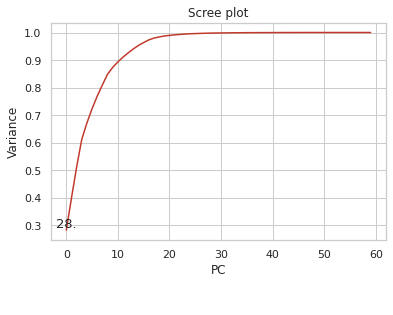

In [ ]:
scree_plot(pca_1)

In [ ]:
std_data_2 = preprocessing.StandardScaler().fit_transform(data_2)
std_data_2 = pd.DataFrame(std_data_2, index = data_2.index, columns = data_2.columns)
std_data_2.head()
pca_2 = PCA(n_components= 43)
pca_2_array = pca_2.fit_transform(std_data_2)
pca_2_df = pd.DataFrame(pca_2_array, index = std_data_2.index, columns = [f"pca{num+1}" for num in range(std_data_2.shape[1])])
pca_2_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39,pca40,pca41,pca42,pca43
0,-1.110101,-1.042080,1.002436,-1.651159,1.270239,-0.182120,-0.270649,-0.786321,-0.147092,-0.065370,-0.110622,0.627659,0.384667,-0.193593,1.204141,-0.021334,-0.656274,0.476941,0.062501,0.161294,-0.136420,0.016629,-0.201697,-0.069370,0.355486,0.003351,0.006571,0.055773,0.005619,-0.000448,0.005724,0.054503,0.009027,-0.025690,-0.002868,0.006040,-0.007302,-0.019098,0.001016,0.007239,-0.000569,-0.000902,0.000561
1,-2.027900,-0.575685,0.851022,-1.428519,1.246104,-0.094427,-1.044476,0.096984,-0.228035,0.057406,-0.492891,-0.131958,0.339035,-0.290649,-0.520580,-0.220308,-0.428885,1.111053,0.001612,0.125369,-0.313308,0.011638,-0.219464,0.064725,0.198948,0.008867,0.013526,0.028682,0.009719,-0.000009,0.000967,0.023890,0.003620,-0.018746,-0.005966,0.016176,-0.017433,-0.002727,-0.002758,0.005483,-0.000041,-0.000479,0.000812
2,-2.092428,1.051018,-0.069748,-0.068252,0.099878,1.147057,-0.507563,0.661692,0.090040,0.436251,-0.369305,-0.483902,0.621441,-0.236467,-0.603072,-0.101703,0.779634,0.390542,0.078709,-1.024902,0.025504,0.124070,-0.291675,-0.584768,0.401457,0.269978,0.459490,0.016697,0.317743,-0.414759,0.146364,-0.075208,0.259383,0.010074,-0.720703,-0.174548,-0.112249,0.017698,0.061217,0.003184,0.005307,-0.006369,0.005235
3,-2.507609,2.016531,1.229610,-0.192164,1.933144,1.147264,-0.607802,1.038992,-0.594586,1.334457,0.400394,-0.457692,0.198948,0.027363,-0.983322,-0.997111,0.009632,0.369204,1.219852,0.963959,-0.062832,0.412604,-0.274297,-0.666632,0.026108,0.048769,-0.231113,0.006125,-0.082986,-0.013093,0.063614,-0.027472,0.031865,0.095803,-0.069823,0.245577,0.487982,-0.062490,0.524553,-0.020073,-0.014969,0.229679,-0.122421
4,-1.916342,1.861670,0.766266,-0.018577,2.063461,1.202082,-1.114448,-0.205088,-0.712173,1.156819,1.150280,-0.112278,0.058753,0.304522,0.014600,-0.502084,-0.468064,0.451967,0.882400,0.614883,-0.240838,0.040357,-0.169781,-0.515781,0.197202,0.409667,-0.260211,0.031787,-0.115887,-0.020738,0.030927,-0.238838,-0.012271,0.123009,-0.010678,0.188159,0.238109,0.781634,0.209087,0.139932,0.031470,0.074649,-0.172968


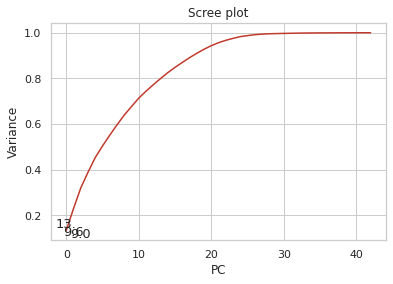

In [ ]:
scree_plot(pca_2)